In [1]:
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
import pickle
import random
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import gc


from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import numpy as np
import gc

In [2]:
#you can load from disk
X_train_with_encoded_feat_df, y_train = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/train_data.pkl", 'rb')) 
X_cv_with_encoded_feat_df, y_cv = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/cv_data.pkl", 'rb'))
X_test_with_encoded_feat_df, SK_ID_CURR_test = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/test_data.pkl", 'rb'))

In [3]:
print("x_train, y_train :", X_train_with_encoded_feat_df.shape, y_train.shape)
print("X_cv, y_test :", X_cv_with_encoded_feat_df.shape, y_cv.shape)
print("x_test, SK_ID_CURR_test :", X_test_with_encoded_feat_df.shape, SK_ID_CURR_test.shape)
X_train_with_encoded_feat_df.head()

x_train, y_train : (246008, 807) (246008,)
X_cv, y_test : (61503, 807) (61503,)
x_test, SK_ID_CURR_test : (48744, 807) (48744,)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,AUTO_ENC_FEAT_229,AUTO_ENC_FEAT_230,AUTO_ENC_FEAT_231,AUTO_ENC_FEAT_232,AUTO_ENC_FEAT_233,AUTO_ENC_FEAT_234,AUTO_ENC_FEAT_235,AUTO_ENC_FEAT_236,AUTO_ENC_FEAT_237,AUTO_ENC_FEAT_238,AUTO_ENC_FEAT_239,AUTO_ENC_FEAT_240,AUTO_ENC_FEAT_241,AUTO_ENC_FEAT_242,AUTO_ENC_FEAT_243,AUTO_ENC_FEAT_244,AUTO_ENC_FEAT_245,AUTO_ENC_FEAT_246,AUTO_ENC_FEAT_247,AUTO_ENC_FEAT_248,AUTO_ENC_FEAT_249,AUTO_ENC_FEAT_250,AUTO_ENC_FEAT_251,AUTO_ENC_FEAT_252,AUTO_ENC_FEAT_253,AUTO_ENC_FEAT_254,AUTO_ENC_FEAT_255,AUTO_ENC_FEAT_256,AUTO_ENC_FEAT_257,AUTO_ENC_FEAT_258,AUTO_ENC_FEAT_259,AUTO_ENC_FEAT_260,AUTO_ENC_FEAT_261,AUTO_ENC_FEAT_262,AUTO_ENC_FEAT_263,AUTO_ENC_FEAT_264,AUTO_ENC_FEAT_265,AUTO_ENC_FEAT_266,AUTO_ENC_FEAT_267,AUTO_ENC_FEAT_268
0,0.052632,0.000858,0.201520,0.149724,0.170000,0.107702,0.880496,0.044770,0.968911,0.730443,0.142857,1.0,1.0,0.0,1.0,0.0,0.0,0.15,1.0,1.0,0.260870,0.0,0.0,0.0,1.0,1.0,0.0,0.136081,0.065394,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,-0.720127,-21.380575,30.214750,54.082024,47.379803,6.802106,10.525236,3.235331,-14.751412,18.335558,-29.882486,49.598232,-12.842958,-0.656301,40.943474,-66.163574,8.720140,-33.289314,-5.587688,-32.323174,-11.933872,27.807922,-15.636991,-21.904446,-14.697936,0.602181,9.064098,24.171661,-64.390938,-34.722599,34.220615,-13.681810,10.667553,-10.333195,48.315311,23.526415,6.872626,-40.929951,-7.971310,5.796223
1,0.052632,0.001204,0.056180,0.046094,0.066667,0.206749,0.566911,0.045762,0.976156,0.426845,0.142857,1.0,1.0,0.0,1.0,1.0,0.0,0.15,0.5,0.5,0.565217,0.0,1.0,1.0,0.0,1.0,1.0,0.340391,0.609292,0.348618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,-7.010778,-32.218906,18.948580,40.786293,32.507893,4.609162,6.759896,8.727826,9.116227,10.863968,-20.035261,57.990475,-19.747673,-11.311634,27.315098,-55.606003,-0.342421,-43.374065,-22.170963,-33.166046,-35.504677,20.055328,-14.847756,-25.783449,-5.792062,-2.412141,3.681906,-2.802591,-55.849709,-20.012156,51.642944,-30.636126,-12.199638,3.060375,59.152279,16.260664,38.686359,-26.992064,-2.300609,-2.562903
2,0.000000,0.001512,0.050506,0.067197,0.055556,0.635991,0.071928,1.000000,0.524054,0.368487,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.10,0.0,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.116083,0.000000,0.1639,0.1395,0.9771,0.6872,0.0625,0.0,0.2759,0.1667,0.2083,0.0000,...,9.225342,-43.894855,52.221966,50.179001,47.181126,11.973767,4.080493,9.645566,3.116079,3.890710,-41.044231,50.709846,-23.527311,-1.377090,53.225128,-36.746056,3.774403,-34.400822,-14.016897,-42.558235,-10.417291,17.336338,-8.127788,-33.159588,-5.296687,-12.881882,-14.321919,-19.438055,-59.030636,-28.822632,39.115864,-20.692703,-16.809919,-3.240363,46.929291,18.130405,28.874016,-45.222668,-8.006999,8.946586
3,0.000000,0.002474,0.157303,0.084899,0.166667,0.141377,0.517813,0.042531,0.963308,0.570654,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.05,1.0,1.0,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.192745,0.000000,0.0557,0.0580,0.9901,0.8640,0.0101,0.0,0.1379,0.1667,0.2083,0.0551,...,12.397394,-24.696718,33.314545,48.298119,42.908489,5.525703,3.561959,-3.482105,0.914114,13.761101,-29.465395,41.662655,-19.363537,-2.294974,46.188873,-41.641846,8.326042,-55.436508,-6.025340,-42.626358,-15.667298,13.805203,-11.722888,-21.029951,2.403604,10.047869,14.108294,-15.3511

In [4]:
X_train_with_encoded_feat_df['TARGET'] = y_train.to_list()
X_cv_with_encoded_feat_df['TARGET'] = y_cv.to_list()
# X_test_with_encoded_feat_df['TARGET'] = y_test.to_list()

In [ ]:
# Reference
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

print('Before over-sampling:')
print(X_train_with_encoded_feat_df.TARGET.value_counts())
# Class count
count_class_0, count_class_1 = X_train_with_encoded_feat_df.TARGET.value_counts()
print(count_class_0, count_class_1)
# Divide by class
df_class_0 = X_train_with_encoded_feat_df[X_train_with_encoded_feat_df['TARGET'] == 0]
df_class_1 = X_train_with_encoded_feat_df[X_train_with_encoded_feat_df['TARGET'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)

X_train_with_encoded_feat_df = pd.concat([df_class_0, df_class_1_over], axis=0)
print('After over-sampling:')
print(X_train_with_encoded_feat_df.TARGET.value_counts())

Before over-sampling:
0    226148
1     19860
Name: TARGET, dtype: int64
226148 19860
After over-sampling:
1    226148
0    226148
Name: TARGET, dtype: int64


In [5]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [6]:

# Train
X_train_with_encoded_feat_df = pd.concat([X_train_with_encoded_feat_df, X_cv_with_encoded_feat_df], ignore_index=True)
# X_train_with_encoded_feat_df = X_train_with_encoded_feat_df
y_train = X_train_with_encoded_feat_df['TARGET']
X_train = X_train_with_encoded_feat_df.drop(columns=['TARGET'])

# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size=0.3, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size=0.5, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)

# # Train
# X_train_with_encoded_feat_df = X_train_with_encoded_feat_df #X_train_with_encoded_feat_df.sample(frac =.50)
# y_train = X_train_with_encoded_feat_df['TARGET']
# X_train = X_train_with_encoded_feat_df.drop(columns=['TARGET'])

# CV
# X_cv_with_encoded_feat_df = X_cv_with_encoded_feat_df.sample(frac =.25)
y_cv = X_cv_with_encoded_feat_df['TARGET']
X_cv = X_cv_with_encoded_feat_df.drop(columns=['TARGET'])

# Test
# X_test_with_encoded_feat_df = X_test_with_encoded_feat_df.sample(frac =.25)
# y_test = X_test_with_encoded_feat_df['TARGET']
# X_test = X_test_with_encoded_feat_df.drop(columns=['TARGET'])
X_test = X_test_with_encoded_feat_df



In [7]:
print("x_train, y_train :", X_train.shape, y_train.shape)
print("X_cv, y_cv :", X_cv.shape, y_cv.shape)
print("x_test, y_test :", X_test.shape, SK_ID_CURR_test.shape)

x_train, y_train : (153755, 807) (153755,)
X_cv, y_cv : (61503, 807) (61503,)
x_test, y_test : (48744, 807) (48744,)


# **Random Model**

 Train Data : 
####################################################################################################
 Train AUC Score Random Model :  0.5001291698549122
 Train F1 - Score Random Model :  0.5002011663225469


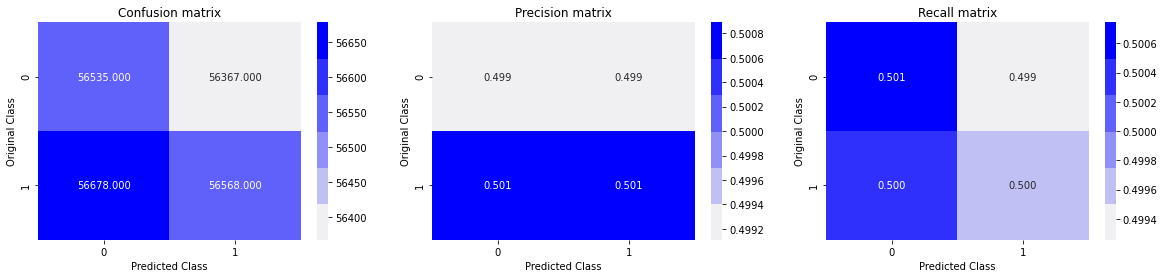

 CV Data : 
####################################################################################################
 Test AUC Score Random Model :  0.4920507545175349
 Test F1 - Score Random Model :  0.135012847726511


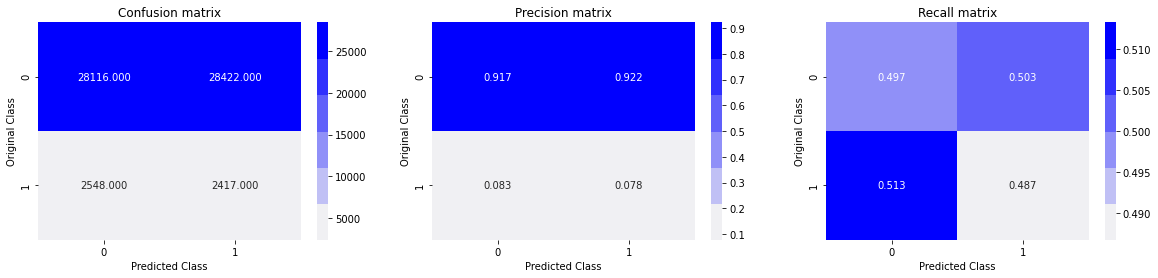

In [ ]:
import random
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# y_train = X_train_balanced_df['TARGET']
# X_train = X_train_balanced_df.drop(columns=['TARGET'])
print(" Train Data : ")
print("#"*100)
randomlist = np.random.rand(X_train.shape[0])
pred_y = [ 1 if val > 0.5 else 0 for val in randomlist]
print(" Train AUC Score Random Model : ", roc_auc_score(y_train.to_list(), pred_y))
print(" Train F1 - Score Random Model : ", f1_score(y_train.to_list(), pred_y))
plot_confusion_matrix(y_train.to_list(), pred_y)

print(" CV Data : ")
print("#"*100)

randomlist = np.random.rand(X_cv.shape[0])
pred_y = [ 1 if val > 0.5 else 0 for val in randomlist]
print(" Test AUC Score Random Model : ", roc_auc_score(y_cv.to_list(), pred_y))
print(" Test F1 - Score Random Model : ", f1_score(y_cv.to_list(), pred_y))
plot_confusion_matrix(y_cv.to_list(), pred_y)
# X_test_with_encoded_feat_df, y_test

# **Logistic Regression**

100%|██████████| 9/9 [4:59:32<00:00, 1996.98s/it]


log_loss for c =  1e-05 is 0.2535900124489589 0.7440763650409777
log_loss for c =  0.0001 is 0.25954084990642545 0.7333100211152981
log_loss for c =  0.001 is 0.2580776669966924 0.7384518186433408
log_loss for c =  0.01 is 0.2633641779187876 0.7400544980094664
log_loss for c =  0.1 is 0.26605650439953876 0.7028340019387187
log_loss for c =  1 is 0.2753664993616989 0.6366966195182044
log_loss for c =  10 is 0.2805432489186437 0.5
log_loss for c =  100 is 0.2805432489186436 0.5
log_loss for c =  1000 is 0.28054324891864363 0.5


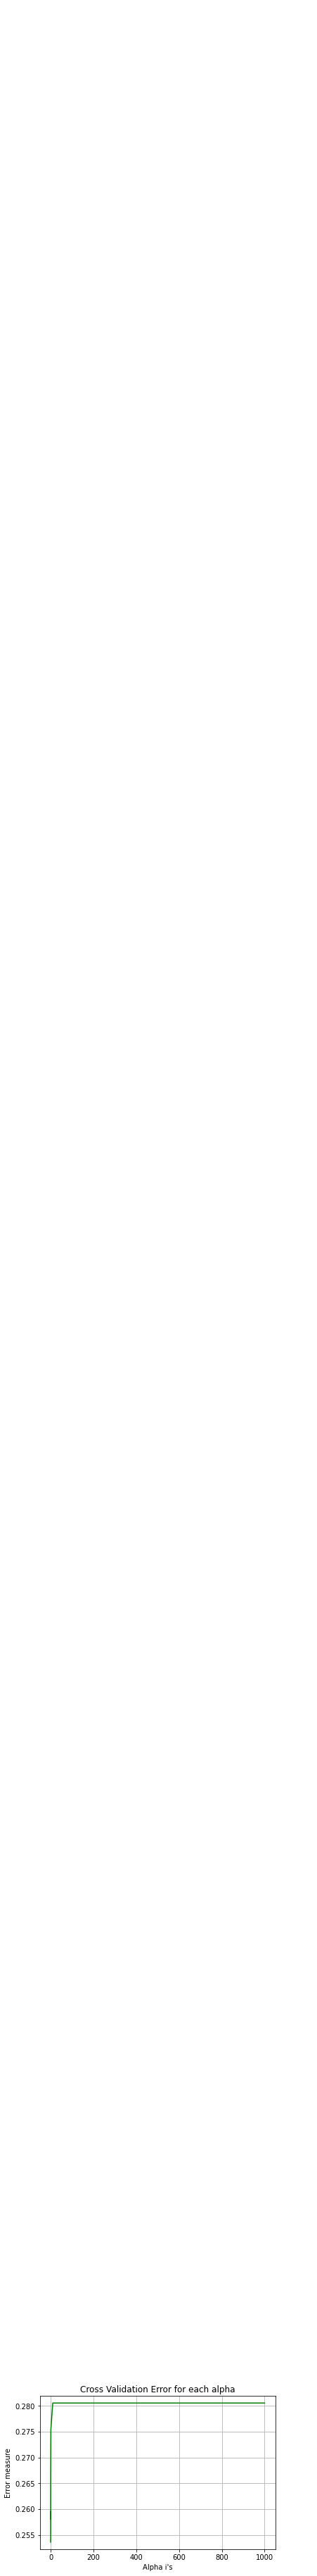

In [ ]:
import warnings

from sklearn.linear_model import SGDClassifier
warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
cv_auc_score = []
for i in tqdm(alpha):
    # LR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train,y_train)
    CC = CalibratedClassifierCV(clf, method="sigmoid")
    CC.fit(X_train,y_train)
    # predict_y = CC.predict_proba(X_cv)
    predict_y = CC.predict_proba(X_cv)[:,1]
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    cv_auc_score.append(roc_auc_score(y_cv,predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i] , cv_auc_score[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

 Train Data : 
####################################################################################################
log loss for train data 0.254796143673776
 Train AUC Score LR Model :  0.7375534826960569
 Train F1 - Score LR Model :  0.0002301628402094482


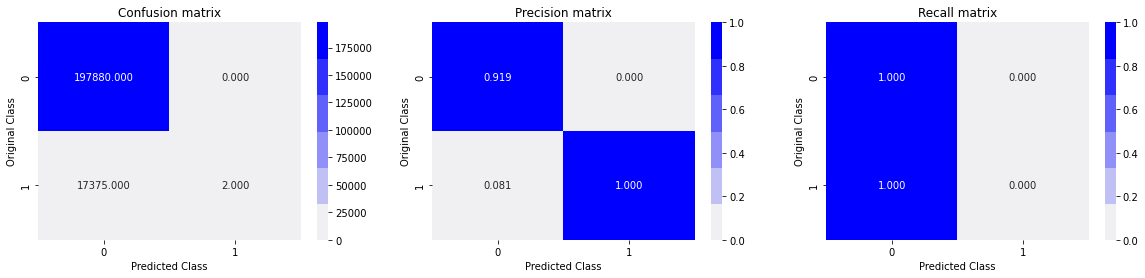

 CV Data : 
####################################################################################################
log loss for cv data 0.2535900124489589
 CV AUC Score LR Model :  0.7440763650409777
 CV F1 - Score LR Model :  0.0


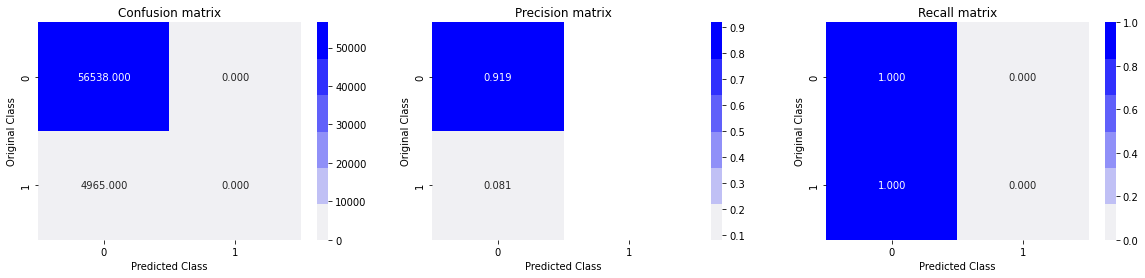

In [ ]:
#PREDICTION WITH BEST ALPHA
# LR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
clf.fit(X_train,y_train)
CC = CalibratedClassifierCV(clf, method="sigmoid")
CC.fit(X_train,y_train)


print(" Train Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)))
print(" Train AUC Score LR Model : ", roc_auc_score(y_train,predict_y[:,1]))
predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
print(" Train F1 - Score LR Model : ", f1_score(y_train,predict_y))
plot_confusion_matrix(y_train, predict_y)

print(" CV Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_cv)
print ('log loss for cv data',(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)))
print(" CV AUC Score LR Model : ", roc_auc_score(y_cv,predict_y[:,1]))
predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
print(" CV F1 - Score LR Model : ", f1_score(y_cv,predict_y))
plot_confusion_matrix(y_cv, predict_y)

# print(" Test Data : ")
# print("#"*100)
# predict_y = CC.predict_proba(X_test)
# print ('log loss for test data',(log_loss(y_test, predict_y, labels=LR.classes_, eps=1e-15)))
# predict_y =np.argmax(predict_y, axis=1)
# print(" Test AUC Score LR Model : ", roc_auc_score(y_test,predict_y))
# print(" Test F1 - Score LR Model : ", f1_score(y_test,predict_y))
# plot_confusion_matrix(y_test, predict_y)

# confusion_matrix(y_test,CC.predict(X_test))


# plot_confusion_matrix(y_test, predict_y)

In [ ]:
print(" Test Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_test)
predict_y = predict_y[:, 1] #np.argmax(predict_y, axis=1)
# initialise data of lists.
data = {'SK_ID_CURR':SK_ID_CURR_test.to_list(),
        'TARGET':predict_y}
 
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/LR_Submission.csv', index=False)
df.head()

 Test Data : 
####################################################################################################


,SK_ID_CURR,TARGET
0,100001,0.041319
1,100005,0.091620
2,100013,0.029848
3,100028,0.061850
4,100038,0.106510


# **Random Forest**

In [ ]:
from tqdm import tqdm
alpha=[50, 100, 150, 200]
max_depth = [7, 10]
cv_log_error_array=[]
cv_auc_score = []
for i in tqdm(alpha):
  for d in max_depth:
    RF=RandomForestClassifier(n_estimators=i, max_depth=d, random_state=42,n_jobs=-1, class_weight='balanced')
    RF.fit(X_train,y_train)
    CC = CalibratedClassifierCV(RF, method="sigmoid")
    CC.fit(X_train,y_train)
    # predict_y = CC.predict_proba(X_cv)
    predict_ty = CC.predict_proba(X_train)[:,1]
    predict_y = CC.predict_proba(X_cv)[:,1]
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=RF.classes_, eps=1e-15))
    cv_auc_score.append(roc_auc_score(y_cv,predict_y))
    print('For n_estimators {0}, max_depth {1} Train AUC {2} cross validation AUC score {3}'.format(i,d,roc_auc_score(y_train,predict_ty), roc_auc_score(y_cv,predict_y)))
    print ('log_loss for c = ',i, d,'is',log_loss(y_cv, predict_y, labels=RF.classes_, eps=1e-15))
    gc.collect()

# for i in range(len(cv_log_error_array)):
#     print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], )


# best_alpha = np.argmin(cv_log_error_array)
# print ('best_alpha = ', best_alpha, alpha[best_alpha])

# fig, ax = plt.subplots()
# ax.plot(alpha, cv_log_error_array,c='g')
# for i, txt in enumerate(np.round(cv_log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()



  0%|          | 0/4 [00:00<?, ?it/s]

For n_estimators 50, max_depth 7 Train AUC 0.7734269822819707 cross validation AUC score 0.7682332840549237
log_loss for c =  50 7 is 0.24515570297785025


 25%|██▌       | 1/4 [22:32<1:07:37, 1352.59s/it]

For n_estimators 50, max_depth 10 Train AUC 0.8742557546082157 cross validation AUC score 0.8403648347873011
log_loss for c =  50 10 is 0.22610873554675567
For n_estimators 100, max_depth 7 Train AUC 0.7758125166879413 cross validation AUC score 0.7699741481609014
log_loss for c =  100 7 is 0.24441022285326425
For n_estimators 100, max_depth 10 Train AUC 0.8760046174085928 cross validation AUC score 0.8418967581518042
log_loss for c =  100 10 is 0.22493947234005696


 50%|█████     | 2/4 [1:07:42<1:11:42, 2151.05s/it]

For n_estimators 150, max_depth 7 Train AUC 0.7757729768893191 cross validation AUC score 0.7697553645620872
log_loss for c =  150 7 is 0.24441765190521458


 75%|███████▌  | 3/4 [2:16:04<50:41, 3041.97s/it]  

For n_estimators 150, max_depth 10 Train AUC 0.8764519536947196 cross validation AUC score 0.8418132488279679
log_loss for c =  150 10 is 0.22471213262032216
For n_estimators 200, max_depth 7 Train AUC 0.7759392333669276 cross validation AUC score 0.7700290088207036
log_loss for c =  200 7 is 0.2443205266878428


100%|██████████| 4/4 [3:44:43<00:00, 3370.78s/it]

For n_estimators 200, max_depth 10 Train AUC 0.8768598606935769 cross validation AUC score 0.8420544148635054
log_loss for c =  200 10 is 0.22445979658915463


 Train Data : 
####################################################################################################
log loss for train data 0.23945543884676634
 Train AUC Score RF Model :  0.7898883907336958
 Train F1 - Score LR Model :  0.004657138268829291


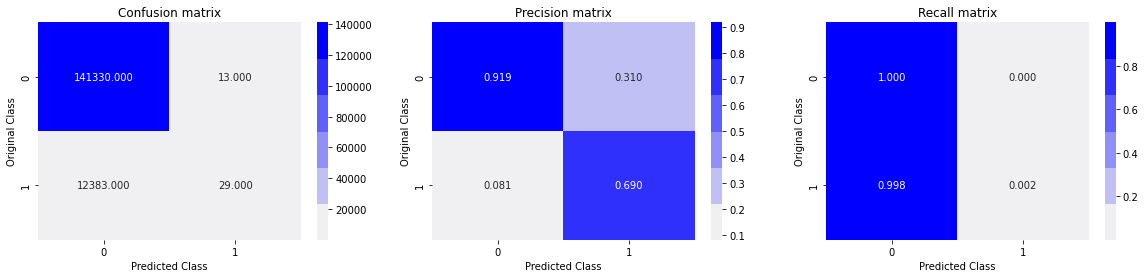

 CV Data : 
####################################################################################################
log loss for cv data 0.2448304345248002
 CV AUC Score RF Model :  0.7688196590110753
 CV F1 - Score LR Model :  0.002814070351758794


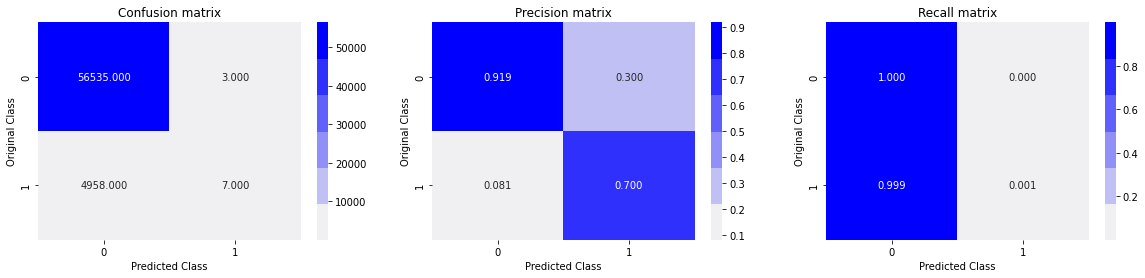

In [ ]:
RF=RandomForestClassifier(n_estimators=200, max_depth=7 ,random_state=42,n_jobs=-1, class_weight='balanced')
RF.fit(X_train,y_train)
CC = CalibratedClassifierCV(RF, method="sigmoid")
CC.fit(X_train,y_train)

print(" Train Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=RF.classes_, eps=1e-15)))
print(" Train AUC Score RF Model : ", roc_auc_score(y_train,predict_y[:,1]))
predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
print(" Train F1 - Score LR Model : ", f1_score(y_train,predict_y))
plot_confusion_matrix(y_train, predict_y)

print(" CV Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_cv)
print ('log loss for cv data',(log_loss(y_cv, predict_y, labels=RF.classes_, eps=1e-15)))
print(" CV AUC Score RF Model : ", roc_auc_score(y_cv,predict_y[:,1]))
predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
print(" CV F1 - Score LR Model : ", f1_score(y_cv,predict_y))
plot_confusion_matrix(y_cv, predict_y)

# print(" Train Data : ")
# print("#"*100)
# predict_y = CC.predict_proba(X_train)
# print ('log loss for train data',(log_loss(y_train, predict_y, labels=CC.classes_, eps=1e-15)))
# predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
# print(" Test AUC Score RF Model : ", roc_auc_score(y_train,predict_y))
# print(" Test F1 - Score RF Model : ", f1_score(y_train,predict_y))
# plot_confusion_matrix(y_train, predict_y)

# print(" CV Data : ")
# print("#"*100)
# predict_y = CC.predict_proba(X_cv)
# print ('log loss for cv data',(log_loss(y_cv, predict_y, labels=CC.classes_, eps=1e-15)))
# predict_y = [1 if y>0.5 else 0 for y in predict_y[:, 1]] #np.argmax(predict_y, axis=1)
# print(" Test AUC Score RF Model : ", roc_auc_score(y_cv,predict_y))
# print(" Test F1 - Score RF Model : ", f1_score(y_cv,predict_y))
# plot_confusion_matrix(y_cv, predict_y)

# print(" Test Data : ")
# print("#"*100)
# predict_y = CC.predict_proba(X_test)
# print ('log loss for test data',(log_loss(y_test, predict_y, labels=CC.classes_, eps=1e-15)))
# predict_y =np.argmax(predict_y, axis=1)
# print(" Test AUC Score RF Model : ", roc_auc_score(y_test,predict_y))
# print(" Test F1 - Score RF Model : ", f1_score(y_test,predict_y))
# plot_confusion_matrix(y_test, predict_y)


In [ ]:
print(" Test Data : ")
print("#"*100)
predict_y = CC.predict_proba(X_test)
predict_y = predict_y[:, 1] #np.argmax(predict_y, axis=1)
# initialise data of lists.
data = {'SK_ID_CURR':SK_ID_CURR_test.to_list(),
        'TARGET':predict_y}
 
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/RF_Submission.csv', index=False)
df.head()

 Test Data : 
####################################################################################################


,SK_ID_CURR,TARGET
0,100001,0.058824
1,100005,0.260660
2,100013,0.035649
3,100028,0.035388
4,100038,0.205848


# **XGBClassifier**

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[10,50,100,200],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 122.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 177.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 237.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 254.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 255.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


 Train Data : 
####################################################################################################
train loss 0.024731406071820776
 Train AUC Score XGBoost Model :  0.9985717686613699
 Train F1 - Score XGBoost Model :  0.9985695627837552


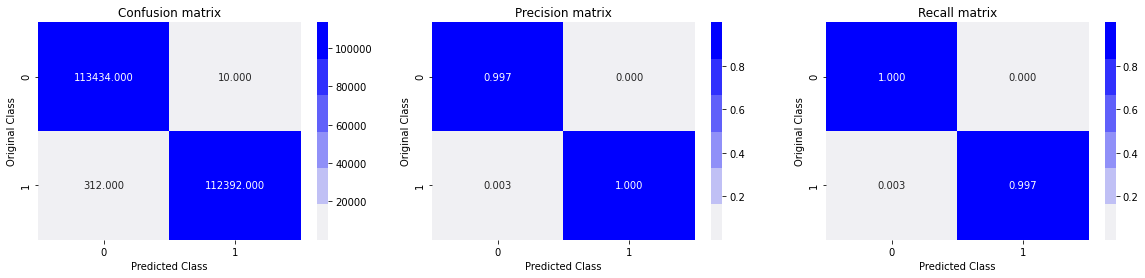

 CV Data : 
####################################################################################################
cv loss 0.33719180788071207
 CV AUC Score XGBoost Model :  0.5682014524039068
 CV F1 - Score XGBoost Model :  0.22252822913797848


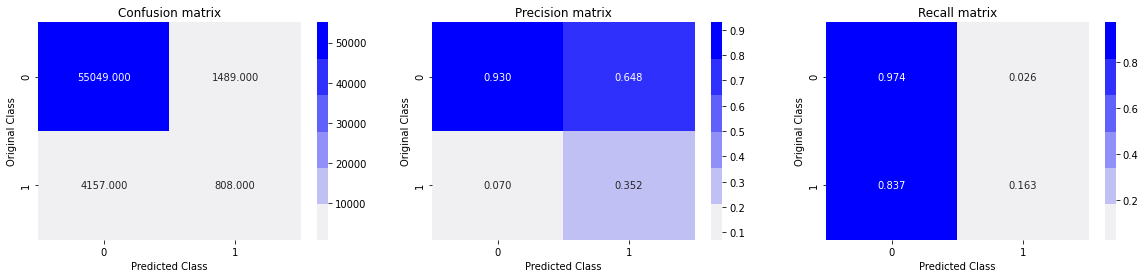

In [ ]:
x_cfl=XGBClassifier(n_estimators=200, subsample=1, max_depth=10, learning_rate=0.2, colsample_bytree=0.5)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

print(" Train Data : ")
print("#"*100)
predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y =np.argmax(predict_y, axis=1)
print(" Train AUC Score XGBoost Model : ", roc_auc_score(y_train,predict_y))
print(" Train F1 - Score XGBoost Model : ", f1_score(y_train,predict_y))
plot_confusion_matrix(y_train, predict_y)

print(" CV Data : ")
print("#"*100)
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y =np.argmax(predict_y, axis=1)
print(" CV AUC Score XGBoost Model : ", roc_auc_score(y_cv,predict_y))
print(" CV F1 - Score XGBoost Model : ", f1_score(y_cv,predict_y))
plot_confusion_matrix(y_cv, predict_y)

# print(" Test Data : ")
# print("#"*100)
# predict_y = c_cfl.predict_proba(X_test)
# print ('test loss',log_loss(y_test, predict_y))
# predict_y =np.argmax(predict_y, axis=1)
# print(" Test AUC Score XGBoost Model : ", roc_auc_score(y_test,predict_y))
# print(" Test F1 - Score XGBoost Model : ", f1_score(y_test,predict_y))
# plot_confusion_matrix(y_test, predict_y)

In [ ]:
print(" Test Data : ")
print("#"*100)
predict_y = c_cfl.predict_proba(X_test)
predict_y =np.argmax(predict_y, axis=1)
# initialise data of lists.
data = {'SK_ID_CURR':SK_ID_CURR_test.to_list(),
        'TARGET':predict_y}
 
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/XGB_Submission.csv', index=False)
df.head()

 Test Data : 
####################################################################################################


,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


# **LGBM**

In [ ]:

import pickle
import random
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#you can load from disk
X_train_with_encoded_feat_df, y_train = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/train_data.pkl", 'rb')) 
X_cv_with_encoded_feat_df, y_cv = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/cv_data.pkl", 'rb'))
X_test_with_encoded_feat_df, SK_ID_CURR_test = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/test_data.pkl", 'rb'))

X_train_with_encoded_feat_df['TARGET'] = y_train.to_list()
X_cv_with_encoded_feat_df['TARGET'] = y_cv.to_list()

# pd.concat([X_train_with_encoded_feat_df, X_cv_with_encoded_feat_df], ignore_index=True)



# Train
X_train_with_encoded_feat_df = pd.concat([X_train_with_encoded_feat_df, X_cv_with_encoded_feat_df], ignore_index=True)
# X_train_with_encoded_feat_df = X_train_with_encoded_feat_df
y_train = X_train_with_encoded_feat_df['TARGET']
X_train = X_train_with_encoded_feat_df.drop(columns=['TARGET'])

# CV
# X_cv_with_encoded_feat_df = X_cv_with_encoded_feat_df.sample(frac =.25)
# y_cv = X_cv_with_encoded_feat_df['TARGET']
# X_cv = X_cv_with_encoded_feat_df.drop(columns=['TARGET'])

# Test
# X_test_with_encoded_feat_df = X_test_with_encoded_feat_df.sample(frac =.25)
# y_test = X_test_with_encoded_feat_df['TARGET']
# X_test = X_test_with_encoded_feat_df.drop(columns=['TARGET'])
X_test = X_test_with_encoded_feat_df



In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import numpy as np
import gc

# folds = KFold(n_splits=2, shuffle=True, random_state=1001)
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

# Iterate through each fold
for train_indices, valid_indices in folds.split(X_train,y_train):
        
    # Training data for the fold
    train_features, train_labels = X_train.iloc[train_indices], y_train.iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = X_train.iloc[valid_indices], y_train.iloc[valid_indices]
        
    # Create the model
    model = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 100)
    
    oof_preds[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    sub_preds += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    # fold_importance_df = pd.DataFrame()
    # fold_importance_df["feature"] = feats
    # fold_importance_df["importance"] = model.feature_importances_
    # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    # print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_labels, oof_preds[valid_indices])))
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.245622	train's auc: 0.773119	valid's binary_logloss: 0.249764	valid's auc: 0.755525
[200]	train's binary_logloss: 0.235826	train's auc: 0.796901	valid's binary_logloss: 0.24333	valid's auc: 0.770907
[300]	train's binary_logloss: 0.229803	train's auc: 0.811683	valid's binary_logloss: 0.240672	valid's auc: 0.777196
[400]	train's binary_logloss: 0.22515	train's auc: 0.823279	valid's binary_logloss: 0.239256	valid's auc: 0.780585
[500]	train's binary_logloss: 0.221252	train's auc: 0.833141	valid's binary_logloss: 0.238585	valid's auc: 0.78221
[600]	train's binary_logloss: 0.217735	train's auc: 0.842071	valid's binary_logloss: 0.23826	valid's auc: 0.782904
[700]	train's binary_logloss: 0.214526	train's auc: 0.850001	valid's binary_logloss: 0.237967	valid's auc: 0.783649
[800]	train's binary_logloss: 0.211562	train's auc: 0.857339	valid's binary_logloss: 0.23781	valid's auc: 0.784082
[900]	train's 

In [ ]:
# test_df['TARGET'] = sub_preds
# test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index= False)

# initialise data of lists.
data = {'SK_ID_CURR':SK_ID_CURR_test.to_list(),
        'TARGET':sub_preds}
 
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/LGBM_Submission.csv', index=False)
df.head()

,SK_ID_CURR,TARGET
0,100001,0.045273
1,100005,0.140693
2,100013,0.033949
3,100028,0.041582
4,100038,0.151800


# **Average Prediction of All Models**

In [ ]:

df_lgbm = pd.read_csv('/content/drive/MyDrive/data/Self-Case-Study-1/LGBM_Submission.csv')
# df_xgb = pd.read_csv('/content/drive/MyDrive/data/Self-Case-Study-1/XGB_Submission.csv')
df_rf = pd.read_csv('/content/drive/MyDrive/data/Self-Case-Study-1/RF_Submission.csv')
df_lr = pd.read_csv('/content/drive/MyDrive/data/Self-Case-Study-1/LR_Submission.csv')



In [ ]:
# initialise data of lists.
data = {'SK_ID_CURR':df_lgbm['SK_ID_CURR'].to_list(),
        'TARGET_LGBM' : df_lgbm['TARGET'],
        # 'TARGET_XGB' : df_xgb['TARGET'],
        'TARGET_RF' : df_rf['TARGET'],
        'TARGET_LR' : df_lr['TARGET'],
        # 'TARGET': (df_lgbm['TARGET'] + df_xgb['TARGET'] + df_rf['TARGET'] + df_lr['TARGET'])/4.0}
        'TARGET': (df_lgbm['TARGET'] + df_rf['TARGET'] + df_lr['TARGET'])/4.0}

 
# Create DataFrame
df = pd.DataFrame(data)
df[['SK_ID_CURR','TARGET']].to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/Avg_Submission.csv', index=False)
df.head()

,SK_ID_CURR,TARGET_LGBM,TARGET_RF,TARGET_LR,TARGET
0,100001,0.045273,0.058824,0.041319,0.036354
1,100005,0.140693,0.260660,0.091620,0.123243
2,100013,0.033949,0.035649,0.029848,0.024862
3,100028,0.041582,0.035388,0.061850,0.034705
4,100038,0.151800,0.205848,0.106510,0.116039


## **Weighted Average Prediction of All Models**

In [ ]:
# initialise data of lists.
lgbm_test_auc = 0.78
rf_test_auc = 0.74
lr_test_auc = 0.72
data = {'SK_ID_CURR':df_lgbm['SK_ID_CURR'].to_list(),
        'TARGET_LGBM' : df_lgbm['TARGET'],
        'TARGET_RF' : df_rf['TARGET'],
        'TARGET_LR' : df_lr['TARGET'],
        'TARGET': (lgbm_test_auc * df_lgbm['TARGET'] + rf_test_auc * df_rf['TARGET'] + lr_test_auc * df_lr['TARGET'])/(lgbm_test_auc + rf_test_auc + lr_test_auc)}
 
# Create DataFrame
df = pd.DataFrame(data)
df[['SK_ID_CURR','TARGET']].to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/Weighted_Avg_Submission.csv', index=False)
df.head()

,SK_ID_CURR,TARGET_LGBM,TARGET_RF,TARGET_LR,TARGET
0,100001,0.045273,0.058824,0.041319,0.048479
1,100005,0.140693,0.260660,0.091620,0.164552
2,100013,0.033949,0.035649,0.029848,0.033193
3,100028,0.041582,0.035388,0.061850,0.046050
4,100038,0.151800,0.205848,0.106510,0.155097


**MULTI-LAYER PERCEPTRON**

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

In [11]:
# determine the number of input features
n_features = X_train.shape[1]
n_features

807

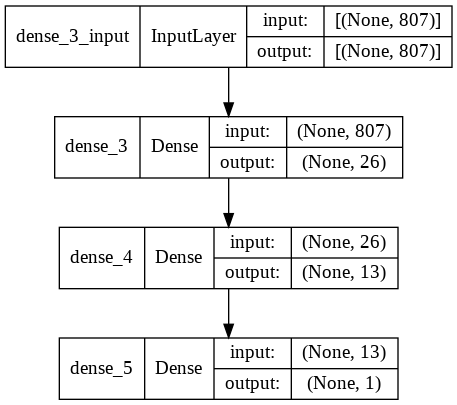

In [13]:
# define model
model = Sequential()
model.add(Dense(26, activation='relu', input_shape=(n_features,)))
model.add(Dense(13, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
4805/4805 [==============================] - 23s 5ms/step - loss: 0.2526 - auc: 0.7361
Epoch 2/150
4805/4805 [==============================] - 22s 4ms/step - loss: 0.2524 - auc: 0.7364
Epoch 3/150
4805/4805 [==============================] - 22s 4ms/step - loss: 0.2523 - auc: 0.7371
Epoch 4/150
4805/4805 [==============================] - 21s 4ms/step - loss: 0.2518 - auc: 0.7390
Epoch 5/150
4805/4805 [==============================] - 22s 5ms/step - loss: 0.2519 - auc: 0.7389
Epoch 6/150
4805/4805 [==============================] - 22s 5ms/step - loss: 0.2520 - auc: 0.7378
Epoch 7/150
4805/4805 [==============================] - 22s 4ms/step - loss: 0.2517 - auc: 0.7392
Epoch 8/150
4805/4805 [==============================] - 22s 4ms/step - loss: 0.2518 - auc: 0.7390
Epoch 9/150
4805/4805 [==============================] - 22s 5ms/step - loss: 0.2517 - auc: 0.7391
Epoch 10/150
4805/4805 [==============================] - 22s 4ms/step - loss: 0.2514 - auc: 0.7405
Epoch 11/

In [22]:
y_pred = model.predict(X_test)
print(y_pred[:10])
y_pred1 = y_pred.round()
print(y_pred1[:10])

[[0.03076761]
 [0.15669483]
 [0.01345644]
 [0.04070157]
 [0.14937466]
 [0.02678996]
 [0.01389586]
 [0.03933763]
 [0.01963535]
 [0.06620194]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [24]:
y_pred[:,0]

array([0.03076761, 0.15669483, 0.01345644, ..., 0.01524035, 0.04604857,
       0.1776075 ], dtype=float32)

In [25]:
# initialise data of lists.
data = {'SK_ID_CURR':SK_ID_CURR_test.to_list(),
        'TARGET':y_pred[:,0]}
 
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/data/Self-Case-Study-1/MLP_Submission.csv', index=False)
df.head()

,SK_ID_CURR,TARGET
0,100001,0.030768
1,100005,0.156695
2,100013,0.013456
3,100028,0.040702
4,100038,0.149375


**Model Comparision**

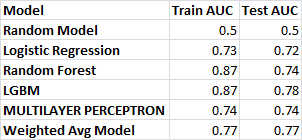

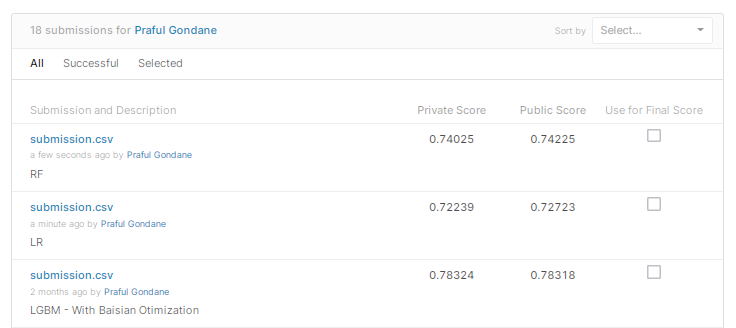

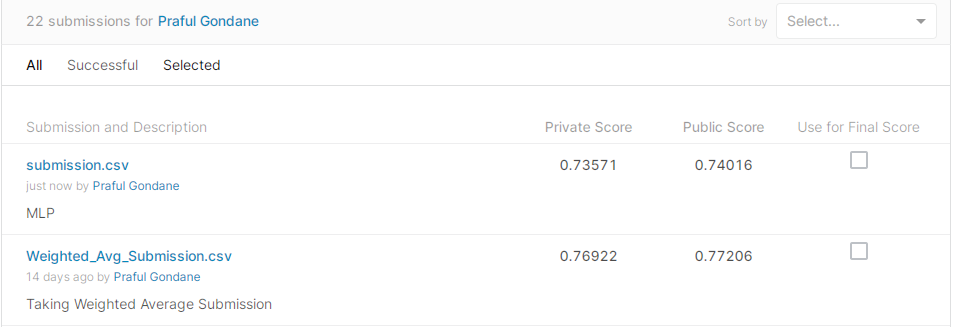